In [1]:
%matplotlib inline

In [2]:
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from dataload import lang, localdata
from tagger.bilstmcrf import BiLSTMCRF
from etc.customUtil import showGraph, showParallel

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
tag_PAD = lang.tag_PAD
tag_UNK = lang.tag_UNK

datasets, engdict, posdict = localdata.load_eng_pos(device)
num_words = engdict.n_words
num_chars = engdict.n_chars
num_poss = posdict.n_words
print(num_words)
print(num_chars)
print(num_poss)
# print(MAX_LENGTH)
print(engdict.max_len_char)
print(engdict.max_len_word)
print(posdict.max_len_char)
print(posdict.max_len_word)

print(len(datasets['dev'].y_data))
print(len(datasets['test'].y_data))
print(len(datasets['train'].y_data))

21591
82
46
54
78
4
78
936
2012
8000


In [5]:
def iteration(samples, optimizer):
    x_train, y_train = samples

    optimizer.zero_grad()

    loss = model(x_train, y_train)
    
    loss.backward()
    optimizer.step()

    return loss

In [6]:
def epoch(model, optimizer, dataloader):
    model.train()
    list_loss = []
    for batch_idx, samples in enumerate(dataloader):
        loss = iteration(samples, optimizer)
        list_loss.append(loss.item())
    return list_loss

In [7]:
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples

        loss = model(x_train, y_train, lossmode=True)
        
        total_loss += loss.item()

        # if batch_idx % 100 == 0:
            # print(batch_idx, loss.item())
            
    # print(batch_idx, loss.item())
    return total_loss / (batch_idx+1)

In [8]:
def scores(model, dataset, batch_size):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    num_samples = len(dataset)
    cnt_corr_samples = 0
    total_words = 0
    cnt_corr_words = 0
    c = posdict.n_words
    table = torch.zeros(c,c)
    
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples
        
        tagged = model(x_train, lossmode=False)
        tagged = torch.tensor(tagged, device=device)
        
        for i in range(x_train.size(0)):
            l = y_train[i].tolist()
            if tag_PAD in l:
                seq_len = l.index(tag_PAD)
            else:
                seq_len = len(l)
            
            _y = y_train[i,:seq_len]
            _p = tagged[i,:seq_len]
            d = _p!=_y
            cnt_wrong = _p[d].size()[0]
            
            # score1_acc_sample
            if cnt_wrong == 0:
                cnt_corr_samples +=1
                
            # score2_acc_word
            total_words += seq_len
            cnt_corr_words += seq_len - cnt_wrong
            
            # score3_f1
            for j in range(seq_len):
                table[_y[j],_p[j]] += 1

    tp = torch.tensor([table[i,i] for i in range(c)])[2:]
    d0sum = table[2:,2:].sum(dim=0)
    d1sum = table[2:,2:].sum(dim=1)
    allsum = d1sum.sum()
    
    pr = tp / d0sum
    temp = pr != pr
    pr[temp] = 0
    
    re = tp / d1sum
    temp = re != re
    re[temp] = 0
    
    f1 = 2 * pr * re / (pr + re)
    temp = f1 != f1
    f1[temp] = 0
    
    avg_f1 = (f1 * d1sum).sum() / allsum
  
    return (cnt_corr_samples / num_samples,
            cnt_corr_words / total_words,
            avg_f1.item())

In [9]:
def train_losses_scores(model, optimizer, datasets, batch_size, num_epoch):

    dict_losses={'train': [],
                 'dev': [],
                 'test': []}
    
    dict_scores={'train': [[],[],[]],
                 'dev': [[],[],[]],
                 'test': [[],[],[]]}
    best_dev_f1 = 0.0
    for epoch_i in range(1,num_epoch+1):
        dataloader = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True)
        dataloader_dev = DataLoader(datasets['dev'], batch_size=len(datasets['dev']), shuffle=True)
        dataloader_test = DataLoader(datasets['test'], batch_size=len(datasets['test']), shuffle=True)
        print(f'\r{epoch_i}', end='')
        temp = epoch(model, optimizer, dataloader)
        dict_losses['train'].extend(temp)
        dict_losses['dev'].append(evaluate(model, dataloader_dev))
        dict_losses['test'].append(evaluate(model, dataloader_test))

        s_train = scores(model, datasets['train'], 100)
        s_dev = scores(model, datasets['dev'], 100)
        s_test = scores(model, datasets['test'], 100)
        
        dict_scores['train'][0].append(s_train[0])
        dict_scores['train'][1].append(s_train[1])
        dict_scores['train'][2].append(s_train[2])
        dict_scores['dev'][0].append(s_dev[0])
        dict_scores['dev'][1].append(s_dev[1])
        dict_scores['dev'][2].append(s_dev[2])
        dict_scores['test'][0].append(s_test[0])
        dict_scores['test'][1].append(s_test[1])
        dict_scores['test'][2].append(s_test[2])
        
        if s_dev[2] > best_dev_f1:
            print(f' epoch Dev F1 score: {best_dev_f1:.6} -> {s_dev[2]:.6}')
            best_dev_f1 = s_dev[2]
            torch.save(model, 'best_bilstm_crf_pos.pt')
    print()
    return dict_losses, dict_scores

In [11]:
def pos_tagging(model, input_seq):
    model.eval()
    o = model(input_seq, lossmode=False)
#     print(o)
#     __tagged, tagged = torch.max(o, dim=-1)
    return o

In [12]:
def calc(model, input_seq, target_seq=None):
    input_list = engdict.sentenceFromIndexes(input_seq.tolist())
#     print(input_list)
    # print(sentenceFromIndexes(posdict, target_seq.tolist()))
    output_list = posdict.sentenceFromIndexes(pos_tagging(model, input_seq.unsqueeze(0))[0])
    
    target_list = None
    if target_seq is not None:
        target_list = posdict.sentenceFromIndexes(target_seq.tolist())

#     print(output_list)
    showParallel(input_list, output_list, target_list)

In [13]:
embedding_dim = 100
size_hidden = 100
num_layers = 2
size_out = num_poss
size_batch = 100
# criterion  = nn.CrossEntropyLoss().to(device)
# criterion  = nn.CrossEntropyLoss(ignore_index=tag_PAD).to(device)

In [14]:
model = BiLSTMCRF(num_words, embedding_dim, size_hidden, size_out, num_layers, tag_PAD).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epoch = 60
st = time.time()
dict_losses, dict_scores = train_losses_scores(model, optimizer, datasets, size_batch, num_epoch)
print(f'\t{time.time()-st:5}')

1 epoch Dev F1 score: 0.0 -> 0.911937
2 epoch Dev F1 score: 0.911937 -> 0.94603
3 epoch Dev F1 score: 0.94603 -> 0.951928
4 epoch Dev F1 score: 0.951928 -> 0.954091
7 epoch Dev F1 score: 0.954091 -> 0.954869
8 epoch Dev F1 score: 0.954869 -> 0.955462
9 epoch Dev F1 score: 0.955462 -> 0.956696
16 epoch Dev F1 score: 0.956696 -> 0.956737
17 epoch Dev F1 score: 0.956737 -> 0.956876
21 epoch Dev F1 score: 0.956876 -> 0.95697
60
	5821.901219129562


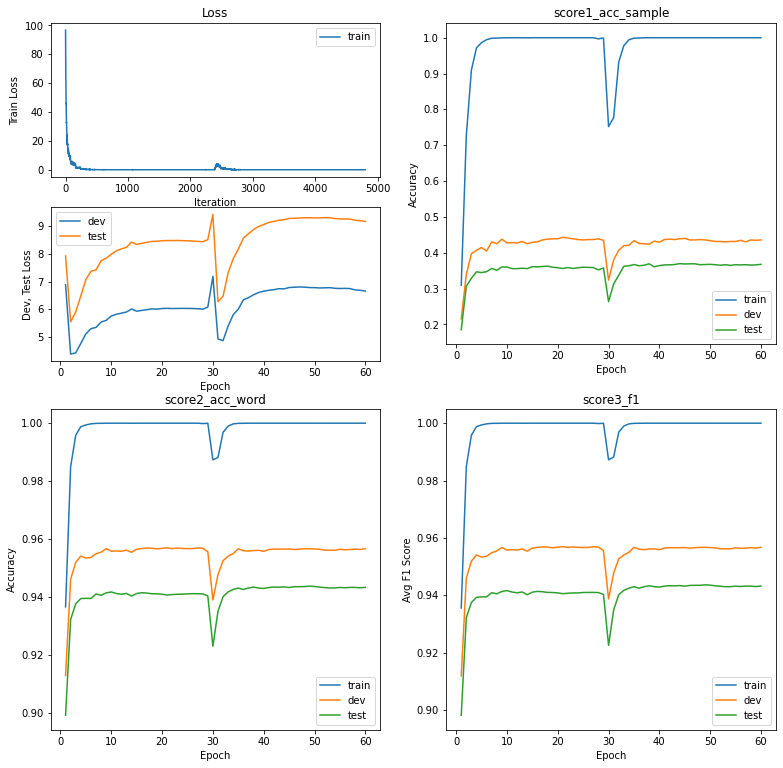

In [15]:
showGraph(dict_losses, dict_scores)

In [16]:
score_type=1
for i in range(len(dict_scores["train"][score_type])):
    print(f'{dict_scores["train"][score_type][i]:<.5}   {dict_scores["dev"][score_type][i]:<05.4}   {dict_scores["test"][score_type][i]:.5}')

0.93654   0.9129   0.89915
0.98498   0.9461   0.93222
0.99584   0.952   0.93763
0.99879   0.9541   0.93942
0.9994   0.9534   0.93951
0.99977   0.9536   0.93946
0.99994   0.9549   0.94101
0.99995   0.9555   0.94056
0.99999   0.9567   0.94141
0.99999   0.9558   0.9417
1.0   0.9559   0.94117
1.0   0.9558   0.94092
0.99999   0.9561   0.9412
0.99999   0.9554   0.94027
1.0   0.9565   0.94117
1.0   0.9567   0.94145
1.0   0.9569   0.94132
1.0   0.9568   0.94109
1.0   0.9566   0.94107
1.0   0.9568   0.94092
1.0   0.957   0.94067
1.0   0.9567   0.94082
1.0   0.9569   0.94092
1.0   0.9567   0.94094
1.0   0.9567   0.94107
1.0   0.9567   0.94111
1.0   0.9569   0.94109
0.99987   0.9568   0.94105
0.99996   0.9556   0.94033
0.98733   0.9389   0.92298
0.98815   0.9477   0.93505
0.99685   0.9525   0.9401
0.999   0.9541   0.94174
0.99975   0.955   0.94259
0.99994   0.9566   0.94305
0.99997   0.956   0.94257
0.99999   0.9558   0.94307
1.0   0.956   0.94339
1.0   0.9561   0.94307
1.0   0.9557   0.94293
1.0

In [17]:
testset = datasets['test']
for ii in range(len(testset)):
    i = 256
    input_seq = testset.x_data[i]
    target_seq = testset.y_data[i]
    calc(model, input_seq, target_seq)
    break
#     print(target_seq)

words               tags    targets
Mr.                 NNP     NNP
Sanford             NNP     NNP
was                 VBD     VBD
told                VBN     VBN
Mr.                 NNP     NNP
Noriega             NNP     NNP
's                  POS     POS
friend              NN      NN
,                   ,       ,
Mr.                 NNP     NNP
Wittgreen           NNP     NNP
,                   ,       ,
would               MD      MD
be                  VB      VB
handling            VBG     VBG
the                 DT      DT
shah                NN      NN
's                  POS     POS
security            NN      NN
.                   .       .


In [18]:
sen = 'I am your father .'
in_sen = torch.tensor(engdict.indexesFromSentence(sen), device=device)

sen2 = [4609,   25,   35,  116, 4610, 1562,   74,  115, 4611,   49, 4612, 1456,
        4613,  224,  691,    6, 4614,   76,   30, 1742, 4615,  308,  107, 4614,
         116, 4616, 4617,   17]
in_sen = torch.tensor(sen2, device=device)

calc(model, in_sen)

words               tags
Rockwell            NNP
International       NNP
Corp.               NNP
's                  POS
Tulsa               NNP
unit                NN
said                VBD
it                  PRP
signed              VBD
a                   DT
tentative           JJ
agreement           NN
extending           VBD
its                 PRP$
contract            NN
with                IN
Boeing              NNP
Co.                 NNP
to                  TO
provide             VB
structural          JJ
parts               NNS
for                 IN
Boeing              NNP
's                  POS
747                 CD
jetliners           NNS
.                   .
